# IRIS data に対するSelf-Attention

Epoch [1/100], Train Loss: 1.3109, Train Accuracy: 60.83%, Test Loss: 1.2138, Test Accuracy: 63.33%
Epoch [2/100], Train Loss: 1.1103, Train Accuracy: 65.83%, Test Loss: 1.0857, Test Accuracy: 63.33%
Epoch [3/100], Train Loss: 1.0657, Train Accuracy: 67.50%, Test Loss: 1.0544, Test Accuracy: 63.33%
Epoch [4/100], Train Loss: 1.0521, Train Accuracy: 56.67%, Test Loss: 1.0359, Test Accuracy: 56.67%
Epoch [5/100], Train Loss: 1.0377, Train Accuracy: 44.17%, Test Loss: 1.0163, Test Accuracy: 40.00%
Epoch [6/100], Train Loss: 1.0188, Train Accuracy: 36.67%, Test Loss: 0.9912, Test Accuracy: 36.67%
Epoch [7/100], Train Loss: 0.9983, Train Accuracy: 38.33%, Test Loss: 0.9657, Test Accuracy: 46.67%
Epoch [8/100], Train Loss: 0.9598, Train Accuracy: 47.50%, Test Loss: 0.9196, Test Accuracy: 56.67%
Epoch [9/100], Train Loss: 0.9122, Train Accuracy: 64.17%, Test Loss: 0.8516, Test Accuracy: 70.00%
Epoch [10/100], Train Loss: 0.8434, Train Accuracy: 65.83%, Test Loss: 0.7718, Test Accuracy: 70.00%

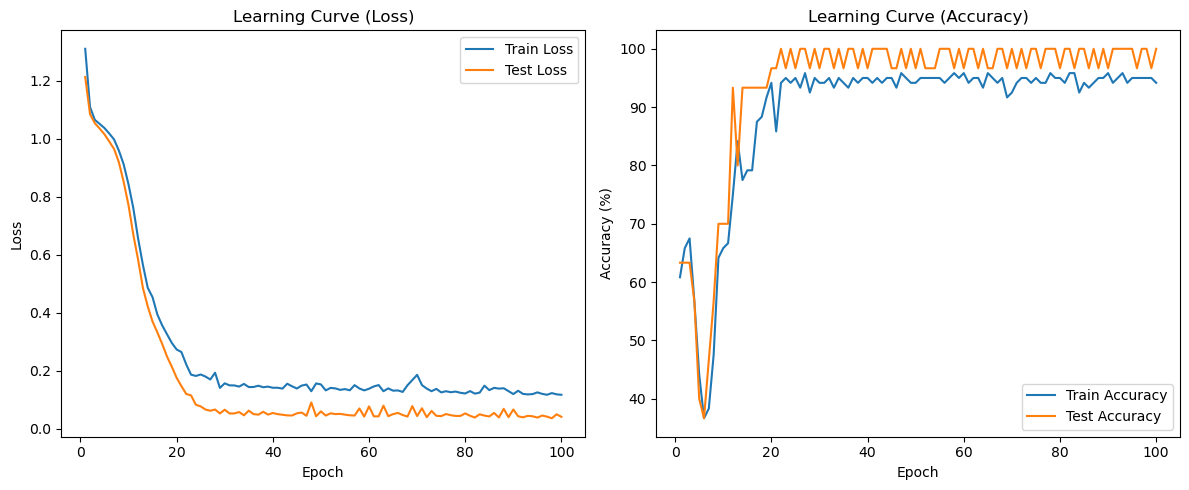

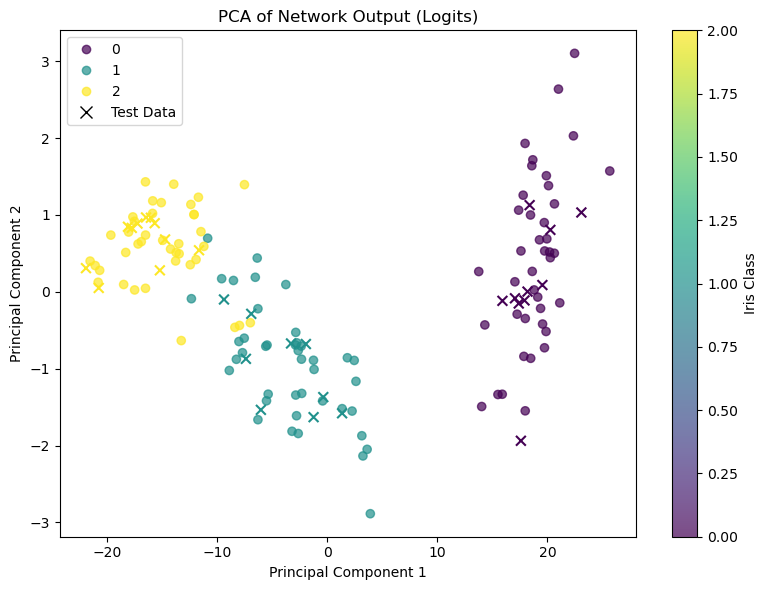

Sample 1 - Attention Weights:
[[9.7662258e-01 1.3080871e-08 2.3377361e-02 3.7107345e-11]
 [7.6616448e-01 2.2756625e-03 2.3121351e-01 3.4632167e-04]
 [9.6122986e-01 1.6231522e-07 3.8769975e-02 1.0453605e-09]
 [5.1748264e-01 8.2457423e-02 3.5454416e-01 4.5515709e-02]]
Sample 2 - Attention Weights:
[[9.9900514e-01 9.9271641e-04 2.1267699e-06 1.4423585e-08]
 [9.6818495e-01 3.0306851e-02 1.3940579e-03 1.1422397e-04]
 [4.0023994e-01 2.6899701e-01 1.8895105e-01 1.4181210e-01]
 [3.3504441e-03 2.7205275e-02 1.7504217e-01 7.9440206e-01]]
Sample 3 - Attention Weights:
[[9.9971360e-01 3.4535137e-07 2.8602814e-04 9.8808607e-11]
 [9.1858405e-01 8.8228853e-03 7.1902379e-02 6.9061341e-04]
 [9.9373561e-01 9.3917704e-05 6.1698384e-03 5.8310991e-07]
 [1.0214659e-01 2.6841465e-01 1.7350718e-01 4.5593166e-01]]
Sample 4 - Attention Weights:
[[9.6641892e-01 3.3384970e-07 3.3580769e-02 7.1785542e-09]
 [7.3378563e-01 7.0479191e-03 2.5704116e-01 2.1252672e-03]
 [9.4468564e-01 3.2898824e-06 5.5310965e-02 1.28421

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Irisデータセットのロード
iris = load_iris()
X = torch.tensor(iris.data, dtype=torch.float32)
y = torch.tensor(iris.target, dtype=torch.long)

# データセットの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# DataLoaderの作成
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=16)

# ニューラルネットワークの定義
class IrisClassifier(nn.Module):
    def __init__(self, num_tokens, num_classes, num_heads=1):
        super(IrisClassifier, self).__init__()
        self.self_attn = nn.MultiheadAttention(embed_dim=1, num_heads=num_heads, batch_first=True)
        self.linear = nn.Linear(num_tokens, num_classes) # 入力は変換後の4つのトークン

    def forward(self, x):
        # 入力形状を (batch_size, seq_len, input_dim) に変更
        # seq_len = 4 (特徴量の数), input_dim = 1 (各特徴量の値)
        x = x.unsqueeze(dim=-1) # [batch_size, 4] -> [batch_size, 4, 1]
        attn_output, _ = self.self_attn(x, x, x) # query, key, valueは同じ
        # Self-attentionの出力形状は (batch_size, seq_len, embed_dim) = (batch_size, 4, 1)
        # 全結合層への入力のために形状を (batch_size, seq_len * embed_dim) = (batch_size, 4) に変更
        attn_output = attn_output.squeeze(dim=-1)
        output = self.linear(attn_output)
        return output

# モデルのインスタンス化
num_tokens = X_train.shape[1]  # 特徴量の数 = 4 (トークン数)
num_classes = len(torch.unique(y))
model = IrisClassifier(num_tokens, num_classes)

# 損失関数とオプティマイザの定義
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 学習曲線を保存するためのリスト
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# 学習ループ
epochs = 100
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    avg_train_loss = train_loss / train_total
    train_accuracy = 100 * train_correct / train_total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # 評価
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    avg_test_loss = test_loss / test_total
    test_accuracy = 100 * test_correct / test_total
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_accuracy)

    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

print('Training finished.')

# 学習曲線のプロット
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve (Loss)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Learning Curve (Accuracy)')
plt.legend()
plt.tight_layout()
plt.show()

# 訓練データのロジットを取得
model.eval()
train_logits = []
train_labels_all = []
with torch.no_grad():
    for inputs, labels in train_loader:
        outputs = model(inputs)
        train_logits.append(outputs.numpy())
        train_labels_all.append(labels.numpy())
train_logits = np.concatenate(train_logits, axis=0)
train_labels_all = np.concatenate(train_labels_all, axis=0)

# テストデータのロジットを取得
test_logits = []
test_labels_all = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        test_logits.append(outputs.numpy())
        test_labels_all.append(labels.numpy())
test_logits = np.concatenate(test_logits, axis=0)
test_labels_all = np.concatenate(test_labels_all, axis=0)

# PCAによる次元削減
pca = PCA(n_components=2)
all_logits = np.vstack((train_logits, test_logits))
pca.fit(all_logits)
train_pca = pca.transform(train_logits)
test_pca = pca.transform(test_logits)

# 可視化
plt.figure(figsize=(8, 6))
scatter = plt.scatter(train_pca[:, 0], train_pca[:, 1], c=train_labels_all, cmap='viridis', label='Train Data', alpha=0.7)
plt.scatter(test_pca[:, 0], test_pca[:, 1], c=test_labels_all, cmap='viridis', marker='x', s=50, label='Test Data')

# カラーバーと凡例
cbar = plt.colorbar(scatter)
cbar.set_label('Iris Class')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Network Output (Logits)')

# クラスごとの凡例を追加
handles, labels = scatter.legend_elements()
plt.legend(handles + [plt.Line2D([0], [0], marker='x', color='black', linestyle='None', markersize=8, label='Test Data')],
           labels + ['Test Data'])

plt.tight_layout()
plt.show()

# いくつかのサンプルに対するSelf-attentionの計算と表示
model.eval()
with torch.no_grad():
    # 最初のバッチのデータを取り出す
    data_iter = iter(train_loader)
    sample_inputs, sample_labels = next(data_iter)

    # 最初の5つのサンプルに対してSelf-attentionを計算
    num_samples_to_show = min(5, sample_inputs.shape[0])
    for i in range(num_samples_to_show):
        input_sample = sample_inputs[i].unsqueeze(0) # バッチ次元を追加
        input_sample_reshaped = input_sample.unsqueeze(dim=-1) # [1, 4] -> [1, 4, 1]
        _, attention_weights = model.self_attn(input_sample_reshaped, input_sample_reshaped, input_sample_reshaped)
        print(f"Sample {i+1} - Attention Weights:\n{attention_weights.squeeze().numpy()}")

    print("-" * 30)

    # 訓練データ中の各クラスのサンプルに対するSelf-attentionの値の平均を計算
    all_train_attention_weights = []
    all_train_labels = []
    for inputs, labels in train_loader:
        inputs_reshaped = inputs.unsqueeze(dim=-1) # [batch_size, 4] -> [batch_size, 4, 1]
        _, attention_weights = model.self_attn(inputs_reshaped, inputs_reshaped, inputs_reshaped)
        all_train_attention_weights.append(attention_weights.squeeze().numpy())
        all_train_labels.append(labels.numpy())

    all_train_attention_weights = np.concatenate(all_train_attention_weights, axis=0)
    all_train_labels = np.concatenate(all_train_labels, axis=0)

    mean_attention_per_class = {}
    for class_id in torch.unique(y).numpy():
        class_indices = np.where(all_train_labels == class_id)[0]
        class_attention_weights = all_train_attention_weights[class_indices]
        mean_attention = np.mean(class_attention_weights, axis=0)
        mean_attention_per_class[f"Class {class_id}"] = mean_attention
        print(f"Mean Attention Weights for Class {class_id}:\n{mean_attention}")

    print("-" * 30)

    # 全結合層の重みをプリント
    for name, param in model.named_parameters():
        if name == 'linear.weight':
            print(f"Linear Layer Weights:\n{param.detach().numpy()}")